In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def get_price_data(symbol='AAPL', period='1y'):
    df = yf.download(symbol, period=period, progress=False)
    df = df[['Close']].rename(columns={'Close': 'price'})
    df.dropna(inplace=True)
    return df

In [3]:
def compute_rolling_volatility(prices, window=20):
    log_returns = np.log(prices / prices.shift(1))
    rolling_std = log_returns.rolling(window=window).std()
    rolling_vol = rolling_std * np.sqrt(252)  # Annualize
    return rolling_vol

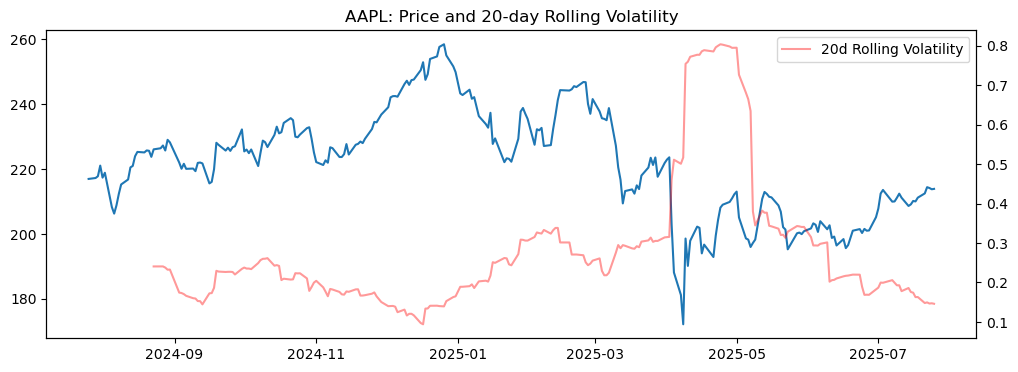

In [4]:
symbol = 'AAPL'
df = get_price_data(symbol, '1y')
df['vol_20d'] = compute_rolling_volatility(df['price'])

plt.figure(figsize=(12,4))
plt.plot(df['price'], label='Adj Close Price')
plt.twinx()
plt.plot(df['vol_20d'], color='red', alpha=0.4, label='20d Rolling Volatility')
plt.title(f'{symbol}: Price and 20-day Rolling Volatility')
plt.legend()
plt.show()

In [5]:
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return np.nan
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    return price

In [6]:
def delta(S, K, T, r, sigma, option_type='call', h=0.01):
    return (
        black_scholes_price(S*(1+h), K, T, r, sigma, option_type) -
        black_scholes_price(S*(1-h), K, T, r, sigma, option_type)
    ) / (2*S*h)

def gamma(S, K, T, r, sigma, option_type='call', h=0.01):
    price_up = black_scholes_price(S*(1+h), K, T, r, sigma, option_type)
    price_mid = black_scholes_price(S, K, T, r, sigma, option_type)
    price_down = black_scholes_price(S*(1-h), K, T, r, sigma, option_type)
    return (price_up - 2*price_mid + price_down) / (S*h)**2

def theta(S, K, T, r, sigma, option_type='call', h=1/252):
    price_today = black_scholes_price(S, K, T, r, sigma, option_type)
    price_tomorrow = black_scholes_price(S, K, T-h, r, sigma, option_type)
    return (price_tomorrow - price_today) / h

def vega(S, K, T, r, sigma, option_type='call', h=0.01):
    price_up = black_scholes_price(S, K, T, r, sigma+h, option_type)
    price_down = black_scholes_price(S, K, T, r, sigma-h, option_type)
    return (price_up - price_down) / (2*h)


In [7]:
def show_dashboard(symbol='AAPL'):
    df = get_price_data(symbol, '1y')
    df['vol_20d'] = compute_rolling_volatility(df['price'])
    latest_price = float(df['price'].iloc[-1])
    latest_vol = float(df['vol_20d'].dropna().iloc[-1])

    # Widgets
    w_S = widgets.FloatSlider(value=latest_price, min=0.5*latest_price, max=1.5*latest_price, step=0.5, description='Spot (S)')
    w_K = widgets.FloatSlider(value=latest_price, min=0.5*latest_price, max=1.5*latest_price, step=0.5, description='Strike (K)')
    w_T = widgets.FloatSlider(value=0.25, min=1/365, max=1.0, step=0.01, description='T (yrs)')
    w_r = widgets.FloatSlider(value=0.05, min=0.0, max=0.1, step=0.001, description='r')
    w_sigma = widgets.FloatSlider(value=latest_vol, min=0.05, max=1.0, step=0.01, description='σ (vol)')
    w_type = widgets.Dropdown(options=['call', 'put'], value='call', description='Type')
    
    def update(S, K, T, r, sigma, option_type):
        price = black_scholes_price(S, K, T, r, sigma, option_type)
        dlt = delta(S, K, T, r, sigma, option_type)
        gmm = gamma(S, K, T, r, sigma, option_type)
        tht = theta(S, K, T, r, sigma, option_type)
        vgg = vega(S, K, T, r, sigma, option_type)
        
        print(f"\nBlack-Scholes {option_type.title()} Price: {price:.2f}")
        print(f"Delta: {dlt:.4f}")
        print(f"Gamma: {gmm:.4f}")
        print(f"Theta: {tht:.4f}")
        print(f"Vega: {vgg:.4f}")
        
        # Plot price as S varies
        S_range = np.linspace(0.5*S, 1.5*S, 100)
        prices = [black_scholes_price(x, K, T, r, sigma, option_type) for x in S_range]
        deltas = [delta(x, K, T, r, sigma, option_type) for x in S_range]
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        plt.plot(S_range, prices)
        plt.xlabel('Spot Price (S)')
        plt.ylabel('Option Price')
        plt.title('Option Price vs Spot')
        plt.subplot(1,2,2)
        plt.plot(S_range, deltas)
        plt.xlabel('Spot Price (S)')
        plt.ylabel('Delta')
        plt.title('Delta vs Spot')
        plt.tight_layout()
        plt.show()
        
    out = widgets.interactive_output(
        update,
        {'S': w_S, 'K': w_K, 'T': w_T, 'r': w_r, 'sigma': w_sigma, 'option_type': w_type}
    )
    ui = widgets.VBox([w_S, w_K, w_T, w_r, w_sigma, w_type])
    display(ui, out)

In [24]:
show_dashboard('FIX')   # You can change 'AAPL' to any ticker!

Output()